# **Dicoding Submission Intermediate Machine Learning Developer Image Classification**

---


Name: Bethelsando Gemilang Wahyudi

---


Dataset: [https://www.kaggle.com/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images/data](https://www.kaggle.com/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images/data)

---






## **Import Library**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetV2B3, Xception, EfficientNetV2S, ResNet50
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

## **Loading Data**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bethelsandogw","key":"048f3afb905739bfe6c6ec52fc95fc8a"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Feb 20 22:18 kaggle.json


In [5]:
!pip install -q kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!pwd

/content


In [9]:
!kaggle datasets list

ref                                                     title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                          Apple Quality                                       170KB  2024-01-11 14:31:07          17848        394  1.0              
mikhail1681/walmart-sales                               Walmart Sales                                       122KB  2024-02-13 17:35:56           1776         33  1.0              
imtkaggleteam/airplane-crashes                          Airplane Crashes 🛫                                  564KB  2024-02-15 21:00:38           1407         55  1.0              
nelgiriyewithana/emotions                               Emotions                                    

In [10]:
!kaggle datasets download -d arjunbasandrai/25-indian-bird-species-with-226k-images

100% 9.33G/9.33G [02:02<00:00, 131MB/s]
100% 9.33G/9.33G [02:02<00:00, 81.7MB/s]


## **Read Data**

In [11]:
!unzip 25-indian-bird-species-with-226k-images.zip training_set/training_set/* -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML285073431.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML285073441.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML285073471.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML285308851.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML285974291.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML286028601.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML286515491.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML286585111.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML288186461.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML288194981.jpg  
  inflating: /content/training_set/training_set/Ruddy Shelduck/ML289170221.jpg  
  inflating: /content/training_set/training_set/Ruddy Shel

In [12]:
os.listdir('/content/training_set/training_set')

['Indian Peacock',
 'Brown-Headed Barbet',
 'Sarus Crane',
 'Common Tailorbird',
 'House Crow',
 'White-Breasted Waterhen',
 'Rufous Treepie',
 'Jungle Babbler',
 'Northern Lapwing',
 'White-Breasted Kingfisher',
 'Common Myna',
 'Asian Green Bee-Eater',
 'Hoopoe',
 'Cattle Egret',
 'Red-Wattled Lapwing',
 'Coppersmith Barbet',
 'Indian Pitta',
 'Gray Wagtail',
 'Common Kingfisher',
 'Indian Grey Hornbill',
 'White Wagtail',
 'Ruddy Shelduck',
 'Common Rosefinch',
 'Indian Roller',
 'Forest Wagtail']

## **Data Exploration**

In [13]:
def create_dataframe(directory):
    files = []
    labels = []

    folders = sorted([folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))])

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        folder_files = glob.glob(os.path.join(folder_path, '*'))

        for file in folder_files:
            files.append(file)
            labels.append(folder)

    data = np.array([files, labels]).T
    df = pd.DataFrame(data, columns=['Path', 'Label'])

    return df
df = create_dataframe('/content/training_set/training_set')

## **Visualize and Balancing**

White-Breasted Waterhen      930
White-Breasted Kingfisher    930
White Wagtail                930
Sarus Crane                  930
Red-Wattled Lapwing          930
Northern Lapwing             930
Jungle Babbler               930
Common Myna                  926
Gray Wagtail                 926
Indian Roller                926
Ruddy Shelduck               925
Brown-Headed Barbet          924
Asian Green Bee-Eater        924
House Crow                   924
Hoopoe                       924
Forest Wagtail               924
Common Kingfisher            924
Indian Grey Hornbill         922
Indian Peacock               919
Common Rosefinch             919
Common Tailorbird            918
Cattle Egret                 918
Rufous Treepie               860
Coppersmith Barbet           778
Indian Pitta                 629
Name: Label, dtype: int64

 Total images:  22620


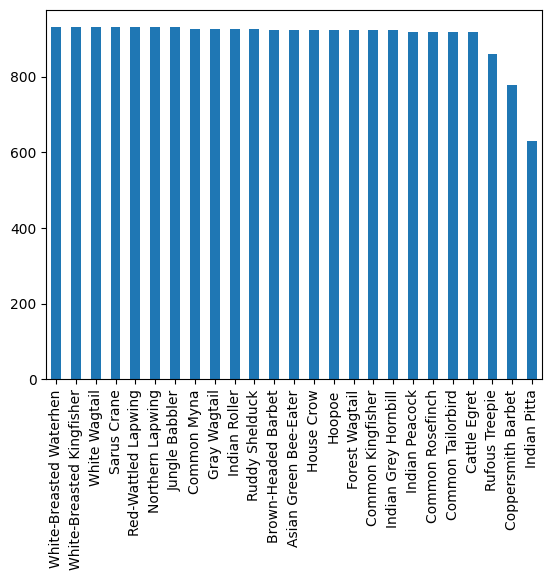

In [14]:
# Lets see total images and in each category

df['Label'].value_counts().plot.bar()
print(df['Label'].value_counts())

print("\n Total images: ", df.shape[0])

### **Undersampling Data**

In [15]:
counter = Counter(df['Label'])
min_samples = min(counter.values())

undersampled_data = pd.DataFrame()

for cls in counter.keys():
    cls_data = df[df['Label'] == cls]
    undersampled_cls_data = resample(cls_data, n_samples=min_samples, random_state=42)
    undersampled_data = pd.concat([undersampled_data, undersampled_cls_data])

df = undersampled_data

Asian Green Bee-Eater        629
Indian Peacock               629
White-Breasted Kingfisher    629
White Wagtail                629
Sarus Crane                  629
Rufous Treepie               629
Ruddy Shelduck               629
Red-Wattled Lapwing          629
Northern Lapwing             629
Jungle Babbler               629
Indian Roller                629
Indian Pitta                 629
Indian Grey Hornbill         629
Brown-Headed Barbet          629
House Crow                   629
Hoopoe                       629
Gray Wagtail                 629
Forest Wagtail               629
Coppersmith Barbet           629
Common Tailorbird            629
Common Rosefinch             629
Common Myna                  629
Common Kingfisher            629
Cattle Egret                 629
White-Breasted Waterhen      629
Name: Label, dtype: int64

 Total images:  15725


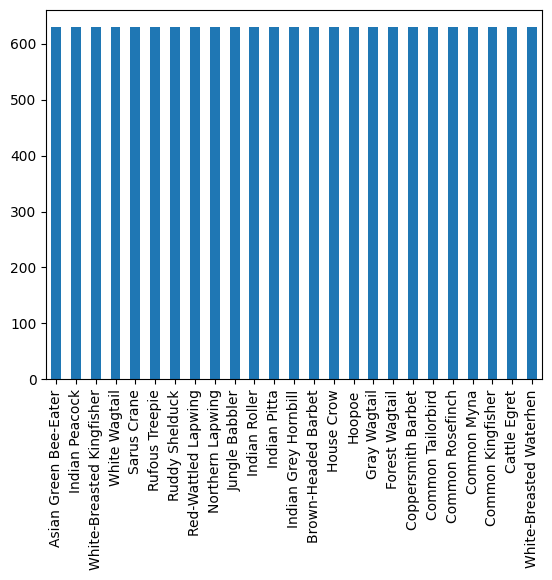

In [16]:
# Lets see total images and in each category

df['Label'].value_counts().plot.bar()
print(df['Label'].value_counts())

print("\n Total images: ", df.shape[0])

## **Data Preprocessing and Augmentation**

### **Spliting Dataset**

In [17]:
train_df, val_df=train_test_split(df, test_size=0.2, shuffle=True, stratify=df['Label'])

Forest Wagtail               504
Hoopoe                       504
Northern Lapwing             504
Common Tailorbird            504
Brown-Headed Barbet          504
Red-Wattled Lapwing          503
Indian Pitta                 503
Rufous Treepie               503
Sarus Crane                  503
Common Myna                  503
Jungle Babbler               503
White-Breasted Waterhen      503
Indian Grey Hornbill         503
Ruddy Shelduck               503
Common Kingfisher            503
White-Breasted Kingfisher    503
Cattle Egret                 503
Gray Wagtail                 503
House Crow                   503
Indian Roller                503
Common Rosefinch             503
Indian Peacock               503
Coppersmith Barbet           503
White Wagtail                503
Asian Green Bee-Eater        503
Name: Label, dtype: int64

 Total images:  12580


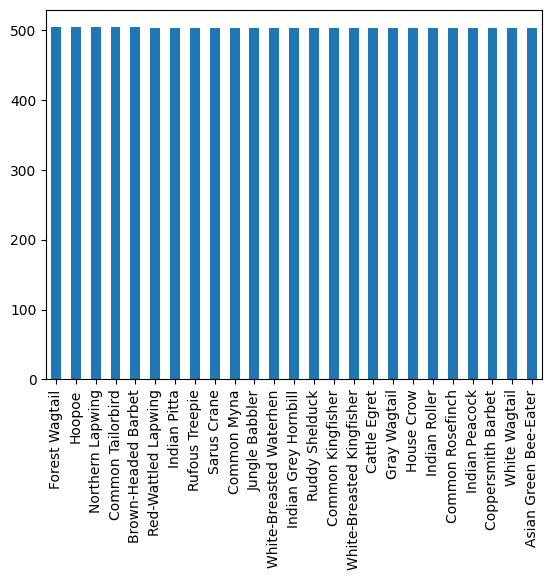

In [18]:
# Lets see total images and in each category

train_df['Label'].value_counts().plot.bar()
print(train_df['Label'].value_counts())

print("\n Total images: ", train_df.shape[0])

Rufous Treepie               126
Cattle Egret                 126
White-Breasted Kingfisher    126
Ruddy Shelduck               126
Indian Roller                126
Red-Wattled Lapwing          126
Gray Wagtail                 126
White-Breasted Waterhen      126
Indian Grey Hornbill         126
Asian Green Bee-Eater        126
White Wagtail                126
Common Myna                  126
Coppersmith Barbet           126
Indian Peacock               126
Common Kingfisher            126
Jungle Babbler               126
Common Rosefinch             126
House Crow                   126
Sarus Crane                  126
Indian Pitta                 126
Brown-Headed Barbet          125
Northern Lapwing             125
Forest Wagtail               125
Common Tailorbird            125
Hoopoe                       125
Name: Label, dtype: int64

 Total images:  3145


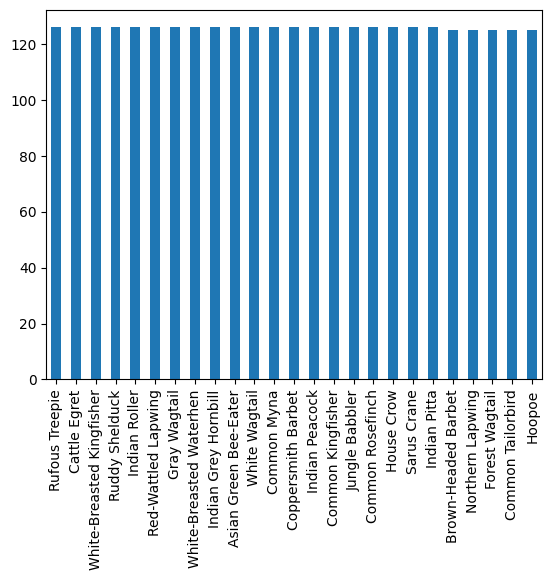

In [19]:
# Lets see total images and in each category

val_df['Label'].value_counts().plot.bar()
print(val_df['Label'].value_counts())

print("\n Total images: ", val_df.shape[0])

### **Data Augmentation**

In [52]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
)

In [21]:
train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle=True,
)

Found 12580 validated image filenames belonging to 25 classes.


In [22]:
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col='Path',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle=True,
)

Found 3145 validated image filenames belonging to 25 classes.


## **Modelling**

### **Model Architecture**

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.applications.EfficientNetV2B3(input_shape=(150, 150, 3), include_top=False, weights='imagenet'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(25, activation='softmax')
])

### **Compile Model**

In [29]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
    )

In [30]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 5, 5, 1536)        12930622  
 nal)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)          884800    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 1, 1, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 512)              

### **Callback**

In [31]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.93 and logs.get('val_accuracy') >= 0.93:
      print(f"Training Stop Accuracy and Val Accuracy more than 93%")
      self.model.stop_training = True

callback_accuracy = myCallback()

In [32]:
callback_earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

### **Training Model**

In [33]:
num_epochs = 30
history = model.fit(
    train_data,
    epochs=num_epochs,
    validation_data=val_data,
    verbose=2,
    callbacks=[callback_accuracy, callback_earlyStopping]
    )

Epoch 1/30
394/394 - 396s - loss: 2.0774 - accuracy: 0.3905 - val_loss: 0.5909 - val_accuracy: 0.8305 - 396s/epoch - 1s/step
Epoch 2/30
394/394 - 297s - loss: 0.6664 - accuracy: 0.8013 - val_loss: 0.3049 - val_accuracy: 0.9132 - 297s/epoch - 753ms/step
Epoch 3/30
394/394 - 274s - loss: 0.3601 - accuracy: 0.8952 - val_loss: 0.2392 - val_accuracy: 0.9367 - 274s/epoch - 695ms/step
Epoch 4/30
Training Stop Accuracy and Val Accuracy more than 93%
394/394 - 262s - loss: 0.2262 - accuracy: 0.9331 - val_loss: 0.2322 - val_accuracy: 0.9393 - 262s/epoch - 666ms/step


### **Visualize Accuracy & Loss**

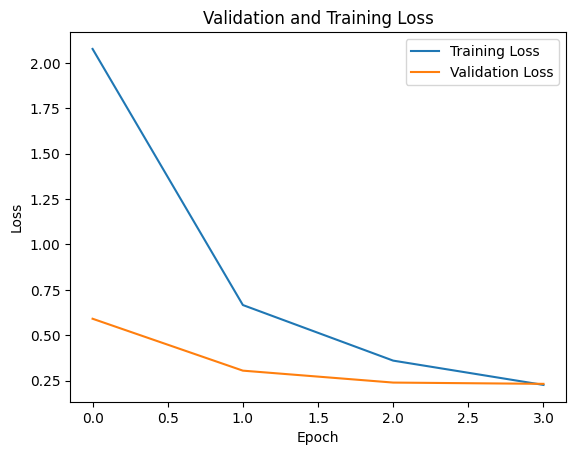

In [34]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation and Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

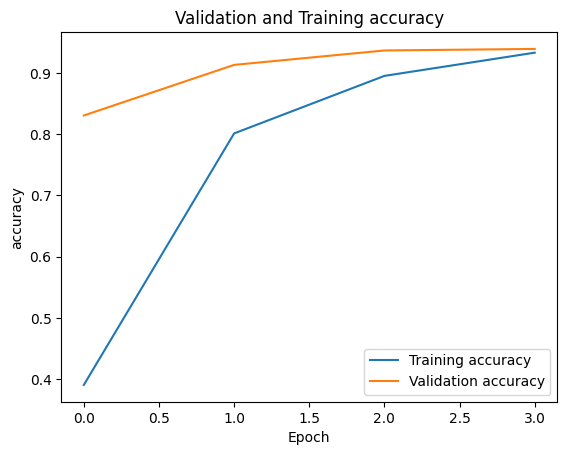

In [35]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Validation and Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### **Evaluate Model**

In [36]:
val_loss_acc = model.evaluate(val_data, steps=len(val_data))

99/99 [==============================] - 48s 489ms/step - loss: 0.2322 - accuracy: 0.9393


In [37]:
pred = model.predict_generator(val_data, steps=len(val_data))

<ipython-input-37-5a1ffb0fd9e4>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(val_data, steps=len(val_data))


In [38]:
y_pred = np.argmax(pred, axis=1)

In [39]:
y_true = val_data.classes

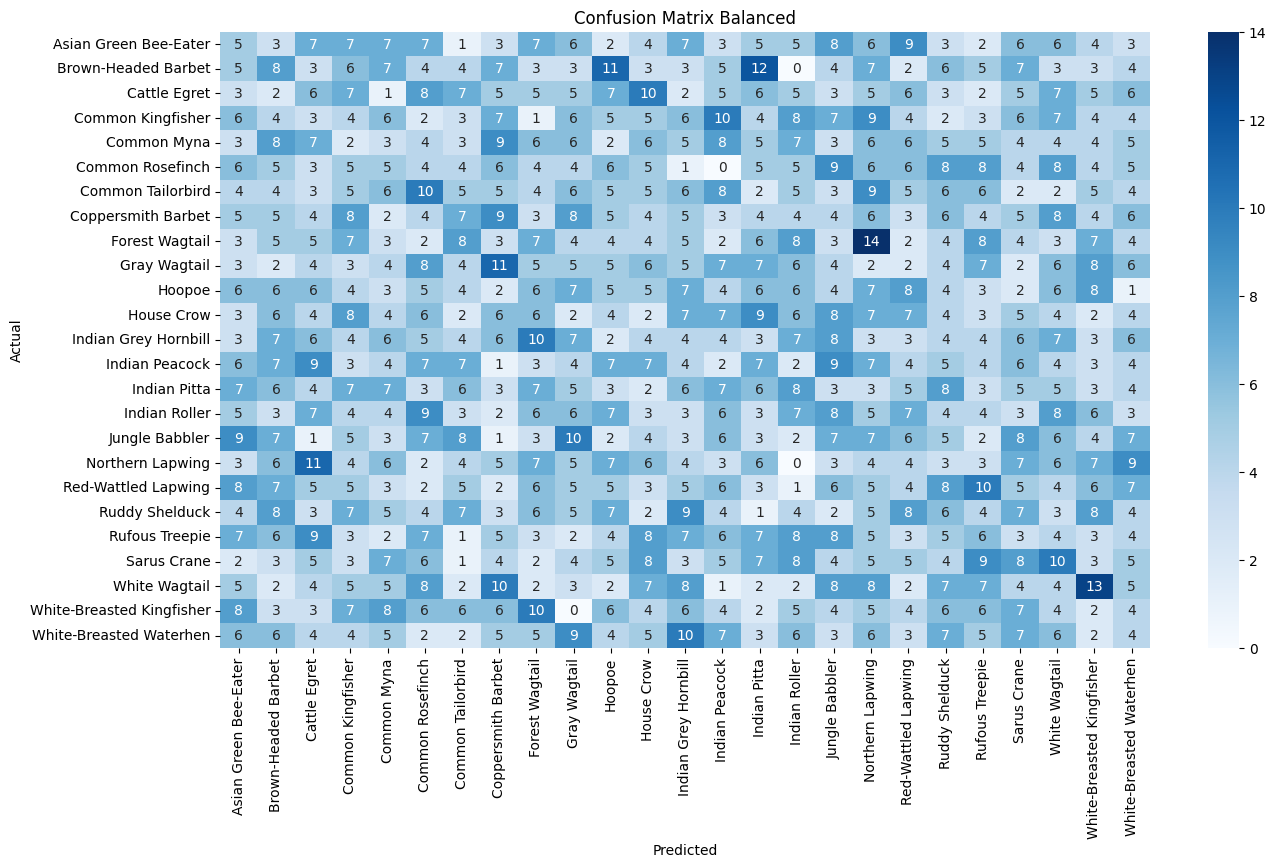

In [53]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Balanced')
plt.show()

## **Saving Model to TF-Lite**

In [47]:
import pathlib
import os

In [49]:
# Menyimpan model dalam format SavedModel
export_dir = '/content/gdrive/MyDrive/Model-Saving/'
tf.saved_model.save(model, export_dir)
# model.save(os.path.join(export_dir, 'model-bird25.h5'))

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/Model-Saving/model-bird25.tflite')
tflite_model_file.write_bytes(tflite_model)

55448100

In [50]:
tflite_model_size = len(tflite_model) / (1024 * 1024)
print('TFLite model size = %d MBs.' % tflite_model_size)

TFLite model size = 52 MBs.
